# Fellowship.ai Challange
##  One Shot Learning - Omniglot.ipynb

It uses the Omniglot dataset which contains 1623 handwritten characters from 50 different alphabets with 20 examples for each alphabet.

We will use two files from the dataset. They can be found by the following two links. 

* https://github.com/brendenlake/omniglot/blob/master/python/images_background.zip 
*  https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip

In [1]:
# Upload the dataset
from google.colab import files

uploaded = files.upload()


Saving images_background.zip to images_background.zip


In [2]:
ev_uploaded = files.upload()

Saving images_evaluation.zip to images_evaluation.zip


## Import necessary packages

In [0]:

import numpy.random as rng
import numpy as np
import os
import dill as pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import cv2
import time

from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy

%matplotlib inline

## Unzip & Load the dataset

In [0]:
!unzip 'images_background.zip'

In [0]:
!unzip 'images_evaluation.zip'

In [0]:
!mkdir save_data
!mkdir weights

In [0]:
def loadimgs(path, n=0):
    '''
    path => Path of train directory or test directory
    '''
    X=[]
    y = []
    cat_dict = {}
    lang_dict = {}
    curr_y = n
    
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        
        # every letter/category has it's own column in the array, so  load seperately
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
            
    y = np.vstack(y)
    X = np.stack(X)
    return X, y, lang_dict

In [0]:
train_folder = 'images_background'
valid_folder = 'images_evaluation'
save_path = 'save_data'
model_path = 'weights'

In [35]:

X, y, c = loadimgs(train_folder)
X.shape, y.shape

loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Bengali
loading alphabet: Greek
loading alphabet: Burmese_(Myanmar)
loading alphabet: Early_Aramaic
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Futurama
loading alphabet: Japanese_(hiragana)
loading alphabet: Sanskrit
loading alphabet: Balinese
loading alphabet: Latin
loading alphabet: Tifinagh
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Cyrillic
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Hebrew
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Gujarati
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: N_Ko
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Armenian
loading alphabet: Korean
loading alphabet: Grantha
loading alphabet: Tagalog
loading alphabet: Braille
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Arcadian
loading alphabet: Japanese_(katakana)


((964, 20, 105, 105), (19280, 1))

In [36]:
c.keys()

dict_keys(['Anglo-Saxon_Futhorc', 'Bengali', 'Greek', 'Burmese_(Myanmar)', 'Early_Aramaic', 'Asomtavruli_(Georgian)', 'Futurama', 'Japanese_(hiragana)', 'Sanskrit', 'Balinese', 'Latin', 'Tifinagh', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Cyrillic', 'Alphabet_of_the_Magi', 'Hebrew', 'Mkhedruli_(Georgian)', 'Gujarati', 'Syriac_(Estrangelo)', 'Malay_(Jawi_-_Arabic)', 'N_Ko', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Armenian', 'Korean', 'Grantha', 'Tagalog', 'Braille', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Japanese_(katakana)'])

In [37]:

c['Bengali'], c['Gujarati']

([29, 74], [550, 597])

In [38]:
X_val, y_val, c_val=loadimgs(valid_folder)
X_val.shape, y_val.shape

loading alphabet: Tibetan
loading alphabet: Malayalam
loading alphabet: Tengwar
loading alphabet: Old_Church_Slavonic_(Cyrillic)
loading alphabet: Glagolitic
loading alphabet: Gurmukhi
loading alphabet: Kannada
loading alphabet: Sylheti
loading alphabet: Keble
loading alphabet: Mongolian
loading alphabet: Manipuri
loading alphabet: Angelic
loading alphabet: Oriya
loading alphabet: Syriac_(Serto)
loading alphabet: ULOG
loading alphabet: Atemayar_Qelisayer
loading alphabet: Aurek-Besh
loading alphabet: Avesta
loading alphabet: Atlantean
loading alphabet: Ge_ez


((659, 20, 105, 105), (13180, 1))

In [0]:
import pickle

with open(os.path.join(save_path,"train.pickle"), "wb") as f:
    pickle.dump((X,c), f)
    
with open(os.path.join(save_path,"val.pickle"), "wb") as f:
    pickle.dump((X_val,c_val), f)

## Loading the train and validation tensors

In [40]:
with open(os.path.join(save_path, "train.pickle"), "rb") as f:
    (X_train, train_classes) = pickle.load(f)
    
print("Training alphabets: \n")
print(list(train_classes.keys()))


with open(os.path.join(save_path, "val.pickle"), "rb") as f:
    (X_val, val_classes) = pickle.load(f)

print("\n\n\nValidation alphabets: \n")
print(list(val_classes.keys()))

Training alphabets: 

['Anglo-Saxon_Futhorc', 'Bengali', 'Greek', 'Burmese_(Myanmar)', 'Early_Aramaic', 'Asomtavruli_(Georgian)', 'Futurama', 'Japanese_(hiragana)', 'Sanskrit', 'Balinese', 'Latin', 'Tifinagh', 'Blackfoot_(Canadian_Aboriginal_Syllabics)', 'Cyrillic', 'Alphabet_of_the_Magi', 'Hebrew', 'Mkhedruli_(Georgian)', 'Gujarati', 'Syriac_(Estrangelo)', 'Malay_(Jawi_-_Arabic)', 'N_Ko', 'Inuktitut_(Canadian_Aboriginal_Syllabics)', 'Armenian', 'Korean', 'Grantha', 'Tagalog', 'Braille', 'Ojibwe_(Canadian_Aboriginal_Syllabics)', 'Arcadian', 'Japanese_(katakana)']



Validation alphabets: 

['Tibetan', 'Malayalam', 'Tengwar', 'Old_Church_Slavonic_(Cyrillic)', 'Glagolitic', 'Gurmukhi', 'Kannada', 'Sylheti', 'Keble', 'Mongolian', 'Manipuri', 'Angelic', 'Oriya', 'Syriac_(Serto)', 'ULOG', 'Atemayar_Qelisayer', 'Aurek-Besh', 'Avesta', 'Atlantean', 'Ge_ez']


In [0]:
def get_batch(batch_size,s="train"):
    """
    Create batch of n pairs, half same class, half different class
    """
    if s == 'train':
        X = X_train
        categories = train_classes
    else:
        X = X_val
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    # randomly sample several classes to use in the batch
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    # initialize 2 empty arrays for the input image batch
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    # initialize vector for the targets
    targets=np.zeros((batch_size,))
    
    # make one half of it '1's, so 2nd half of batch has same class
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    
    return pairs, targets
  
def generate(batch_size, s="train"):
    """
    a generator for batches, so model.fit_generator can be used.
    """
    while True:
        pairs, targets = get_batch(batch_size, s)
        yield (pairs, targets)

In [0]:
def make_oneshot_task(N, s="val", language=None):
    """Create pairs of test image, support set for testing N way one-shot learning. """
    if s == 'train':
        X = X_train
        categories = train_classes
    else:
        X = X_val
        categories = val_classes
    n_classes, n_examples, w, h = X.shape
    
    indices = rng.randint(0, n_examples,size=(N,))
    if language is not None: # if language is specified, select characters for that language
        low, high = categories[language]
        if N > high - low:
            raise ValueError("This language ({}) has less than {} letters".format(language, N))
        categories = rng.choice(range(low,high),size=(N,),replace=False)
    else: # if no language specified just pick a bunch of random letters
        categories = rng.choice(range(n_classes),size=(N,),replace=False)            
    
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([X[true_category,ex1,:,:]]*N).reshape(N, w, h,1)
    support_set = X[categories,indices,:,:]
    support_set[0,:,:] = X[true_category,ex2]
    support_set = support_set.reshape(N, w, h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]
        
    return pairs, targets
  
def test_oneshot(model, N, k, s = "val", verbose = 0):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {} way one-shot learning tasks ... ".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N,s)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0 * n_correct / k)
    if verbose:
        print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
        
    return percent_correct

In [0]:
def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

## Model

In [0]:
def model(input_shape=(105, 105, 1)):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # build convnet to use in each siamese 'leg'
    convnet = Sequential()
    convnet.add(Conv2D(64,(10,10),activation='relu',input_shape=input_shape,
                       kernel_initializer=W_init,kernel_regularizer=l2(2e-4)))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128,(7,7),activation='relu',
                       kernel_regularizer=l2(2e-4),kernel_initializer=W_init,bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(128,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
    convnet.add(MaxPooling2D())
    convnet.add(Dropout(0.2))
    
    convnet.add(Conv2D(256,(4,4),activation='relu',kernel_initializer=W_init,kernel_regularizer=l2(2e-4),bias_initializer=b_init))
    convnet.add(Flatten())
    convnet.add(Dense(4096,activation="sigmoid",kernel_regularizer=l2(1e-3),kernel_initializer=W_init,bias_initializer=b_init))
    
    # encode each of the two inputs into a vector with the convnet
    encoded_l = convnet(left_input)
    encoded_r = convnet(right_input)
    
    # merge two encoded inputs with the l1 distance between them
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    prediction = Dense(1,activation='sigmoid',bias_initializer=b_init)(L1_distance)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    # optimizer = SGD(0.0004,momentum=0.6,nesterov=True,decay=0.0003)
    optimizer = Adam(0.0001)
    # get layerwise learning rates and momentum annealing scheme described in paperworking
    siamese_net.compile(loss="binary_crossentropy", optimizer=optimizer)
    
    return siamese_net



In [45]:
model = model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38947648    input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________________

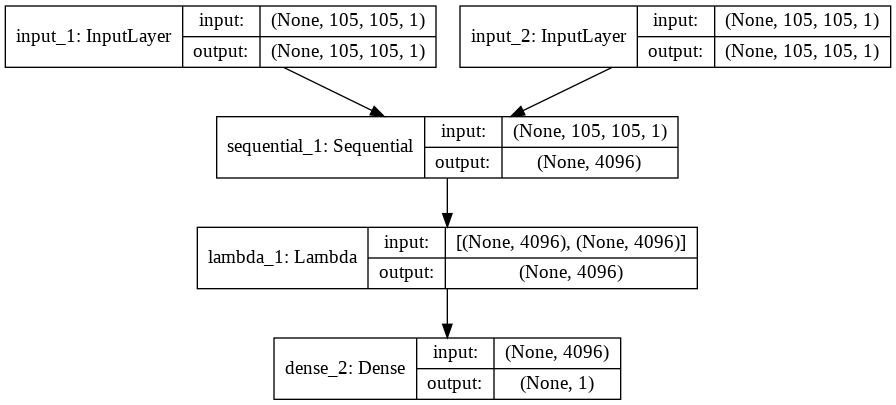

In [46]:
from keras.utils import plot_model
import IPython

plot_model(model, show_shapes=True, show_layer_names=True)
IPython.display.Image('model.png')

In [0]:

def training_starts(evaluate_every=250, batch_size=32, n_iter=10000, N_way=20, n_val=250):
    '''
    Hyper parameters
    
    evaluate_every : interval for evaluating on one-shot tasks
    batch_size : batch size
    n_iter : No. of training iterations
    N_way : how many classes for testing one-shot tasks
    n_val : how many one-shot tasks to validate on
    '''
    
    print("Starting training process!")
    print("-------------------------------------")
    best = -1
    t_start = time.time()
    
    for i in range(1, n_iter+1):
        (inputs, targets) = get_batch(batch_size)
        loss = model.train_on_batch(inputs, targets)
        
        if i % evaluate_every == 0:
            print("\n ------------- \n")
            print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
            print("Train Loss: {0}".format(loss)) 
            val_acc = test_oneshot(model, N_way, n_val, verbose=True)
            
            if val_acc >= best:
                print("Current best: {0}, previous best: {1}".format(val_acc, best))
                model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(val_acc)))
                best = val_acc
                
    print("-------------------------------------")

In [48]:
%%time

training_starts()

Starting training process!
-------------------------------------
Instructions for updating:
Use tf.cast instead.

 ------------- 

Time for 250 iterations: 0.9594136635462444 mins
Train Loss: 2.207240343093872
Evaluating model on 250 random 20 way one-shot learning tasks ... 
Got an average of 29.2% 20 way one-shot learning accuracy 

Current best: 29.2, previous best: -1

 ------------- 

Time for 500 iterations: 1.9148732741673788 mins
Train Loss: 1.5451680421829224
Evaluating model on 250 random 20 way one-shot learning tasks ... 
Got an average of 35.2% 20 way one-shot learning accuracy 

Current best: 35.2, previous best: 29.2

 ------------- 

Time for 750 iterations: 2.8636964480082194 mins
Train Loss: 1.1698708534240723
Evaluating model on 250 random 20 way one-shot learning tasks ... 
Got an average of 36.0% 20 way one-shot learning accuracy 

Current best: 36.0, previous best: 35.2

 ------------- 

Time for 1000 iterations: 3.813950792948405 mins
Train Loss: 0.77539044618606

In [0]:
model.compile(loss="binary_crossentropy", optimizer=Adam(0.00001))

In [50]:

training_starts()

Starting training process!
-------------------------------------

 ------------- 

Time for 250 iterations: 0.8605678160985311 mins
Train Loss: 0.2445528507232666
Evaluating model on 250 random 20 way one-shot learning tasks ... 
Got an average of 76.8% 20 way one-shot learning accuracy 

Current best: 76.8, previous best: -1

 ------------- 

Time for 500 iterations: 1.8079162160555522 mins
Train Loss: 0.2148413211107254
Evaluating model on 250 random 20 way one-shot learning tasks ... 
Got an average of 77.2% 20 way one-shot learning accuracy 

Current best: 77.2, previous best: 76.8

 ------------- 

Time for 750 iterations: 2.7542219320933023 mins
Train Loss: 0.25423911213874817
Evaluating model on 250 random 20 way one-shot learning tasks ... 
Got an average of 78.4% 20 way one-shot learning accuracy 

Current best: 78.4, previous best: 77.2

 ------------- 

Time for 1000 iterations: 3.7025930086771646 mins
Train Loss: 0.3887113034725189
Evaluating model on 250 random 20 way one-

In [0]:
model.load_weights(os.path.join(model_path, "weights.82.8.h5"))

In [0]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,"val")
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials

In [0]:
ways = np.arange(1,20,2)
resume =  False
trials = 50

In [54]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
    val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
    train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("-----------------------------------------------------------------------------------")

Evaluating model on 50 random 1 way one-shot learning tasks ... 
Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating model on 50 random 1 way one-shot learning tasks ... 
Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 1 way one-shot learning tasks ...
NN Accuracy =  100.0
-----------------------------------------------------------------------------------
Evaluating model on 50 random 3 way one-shot learning tasks ... 
Got an average of 98.0% 3 way one-shot learning accuracy 

Evaluating model on 50 random 3 way one-shot learning tasks ... 
Got an average of 98.0% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 50 unique 3 way one-shot learning tasks ...
NN Accuracy =  54.0
-----------------------------------------------------------------------------------
Evaluating model on 50 random 5 way one-shot learning tasks ... 
Got an average of 96.0% 5 way one-shot learning accuracy 

Evaluating model 

## Save the accuracies on disk, then loaded

In [0]:
with open(os.path.join(save_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)
    
    
with open(os.path.join(save_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [0]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, h , w, _ = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img


def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

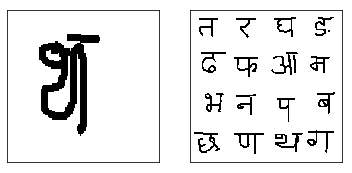

In [57]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16, "train", "Sanskrit")
plot_oneshot_task(pairs)

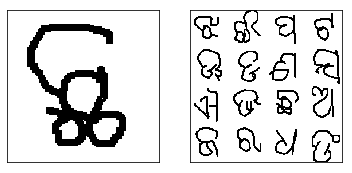

In [58]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(16, "val", "Oriya")
plot_oneshot_task(pairs)

## Result

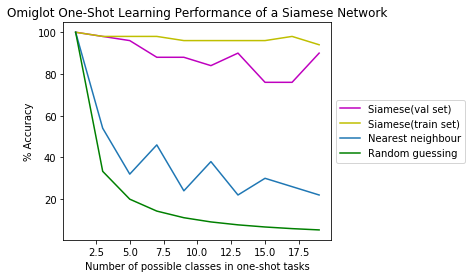

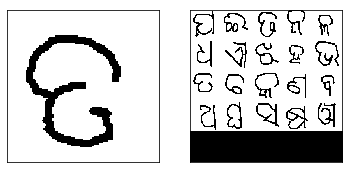

In [59]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Omiglot One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

plot_oneshot_task(inputs)